In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
from google.colab import drive
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [ ]:

f = open('/content/drive/MyDrive/4th_Sem/DL/A2/train_set.pkl', 'rb')   
mat = pickle.load(f)         # load file content as mydict
f.close()

f1 = open('/content/drive/MyDrive/4th_Sem/DL/A2/val_set.pkl', 'rb')  
mat1 = pickle.load(f1)         
f1.close()

X = mat['Image']
X_train=np.empty(shape=(10000,28,28),dtype='float')
Y_train = mat['Labels']
for x in range(len(X)):
  X_train[x] = np.asarray(X[x])

X_train = X_train.reshape(10000,784).T/255
print(X_train.shape)
print(Y_train.shape)

X = mat1['Image']
X_val=np.empty(shape=(2000,28,28),dtype='float')
Y_val = mat1['Labels']
for x in range(len(X)):
  X_val[x] = np.asarray(X[x])

X_val = X_val.reshape(2000,784).T/255
print(X_val.shape)
print(Y_val.shape)

(784, 10000)
(10000,)
(784, 2000)
(2000,)


In [ ]:
class activation:
  def __init__(self,func):
    self.func=func

  def forward_activation(self,Z):
    if self.func == 'ReLU':
      return np.maximum(Z, 0)
    elif self.func == 'sigmoid':
      return 1/(1+np.exp(-Z))
    elif self.func == 'tanh':
      return 2/(1+np.exp(-2*Z))-1

  def back_activation(self,Z):
    if self.func == 'ReLU':
      return (Z > 0)
    elif self.func == 'sigmoid':
      return (1/(1+np.exp(-Z)))*(1-1/(1+np.exp(-Z)))
    elif self.func == 'tanh':
      return 1-(2/(1+np.exp(-2*Z))-1)*(2/(1+np.exp(-2*Z))-1)


In [ ]:
class optimize():
  def __init__(self,opt):
    self.opt=opt

  def optimizer(self,lr,W1, b1, W2, b2,dW1, db1, dW2, db2):
   if (self.opt=='SGD'):
      W1 = W1 - lr * dW1
      b1 = b1 - lr * db1    
      W2 = W2 - lr * dW2  
      b2 = b2 - lr * db2  
      return W1,b1,W2,b2

    #elif (opt=='GDM'):

      #return W1,b1,W2,b2




    


In [ ]:
class MLPClassifier(activation,optimize):
  
  def __init__(self,lr,epochs,func,opt='SGD'):
    self.X=0
    self.Y=0
    self.lr=lr
    self.epochs=epochs
    activation.__init__(self,func)
    optimize.__init__(self,opt)


  def init_random(self):
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2
  
  def softmax(self,Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

  def forward_prop(self,X,W1, b1, W2, b2):
    Z1 = W1.dot(X) + b1
    A1 = self.forward_activation(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = self.softmax(Z2)
    return Z1, A1, Z2, A2

  def backward_prop(self,Z1, A1, Z2, A2, W1, b1, W2, b2,X,Y):
    
    m=Y.size
    one_hot_Y = label_binarize(Y, classes=[0, 1, 2,3,4,5,6,7,8,9])
    dZ2 = A2 - one_hot_Y.T
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * self.back_activation(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2


  def fit(self,X1,Y1,X2,Y2):
    X_train=X1
    Y_train=Y1
    X_test=X2
    y_test=Y2


    
    W1, b1, W2, b2 = self.init_random()
    Train_loss=[]
    Test_loss=[]
    Epochs=[]

    for i in range(self.epochs):
        Z1, A1, Z2, A2 = self.forward_prop(X_train,W1, b1, W2, b2)
        dW1, db1, dW2, db2 = self.backward_prop(Z1, A1, Z2, A2, W1, b1, W2, b2,X_train,Y_train)
        W1,b1,W2,b2=self.optimizer(self.lr,W1, b1, W2, b2,dW1, db1, dW2, db2)
        _, _, _, Y_pred = self.forward_prop(X_test,W1, b1, W2, b2)

        if i % 10 == 0:
            predictions = np.argmax(A2, 0)
            
            Y_pred= np.argmax(Y_pred, 0)
            Y_pred=np.array(Y_pred)
            y_true=np.array(Y_train)

            acc=np.sum(predictions == Y_train) / Y_train.size
            acc_test=np.sum(Y_pred == y_test) / y_test.size
            err_train=mean_squared_error(Y_train, predictions)
            err_test=mean_squared_error(y_test, Y_pred)
            Train_loss.append(err_train)
            Test_loss.append(err_test)
            Epochs.append(i)

    return W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs,acc_test

  def get_predictions(self,X_train,Y_train,X_test):
    W1, b1, W2, b2,_, _, _, _ = self.fit(X_train,Y_train)
    Z1, A1, Z2, A2 = self.forward_prop(X_train,W1, b1, W2, b2)
    predictions = np.argmax(A2, 0)
    return predictions

  def get_loss(self,X,Y):
    W1, b1, W2, b2,predictions,acc,train_loss,test_loss,epochs=self.fit(X,Y)
    return train_loss,test_loss,epochs

  def get_proba(self,X_train,Y_train):
    _,_,_,_,A=self.fit(X_train,Y_train)
    return A

  def get_params(self,X_train,Y_train):
    W1, b1, W2, b2 , _,_=self.fit(X_train,Y_train)
    return W1, b1, W2, b2

  def Score(self,X_train,Y_train):
    _, _, _, _ , _,acc=self.fit(X_train,Y_train)
    return acc
    


SGD with ReLU

In [ ]:
model= MLPClassifier(0.1,500,'ReLU')
y_train=Y_train
W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs,Proba=model.fit(X_train,y_train,X_val,Y_val)

In [ ]:
Y_train=label_binarize(Y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])
Y_train.T[:,5]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
print('MLP accuracy With ReLU',acc)

MLP accuracy With ReLU 0.8632


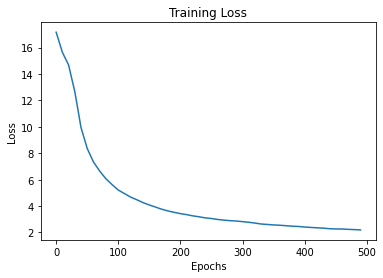

In [ ]:
plt.plot(Epochs,Train_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show() 

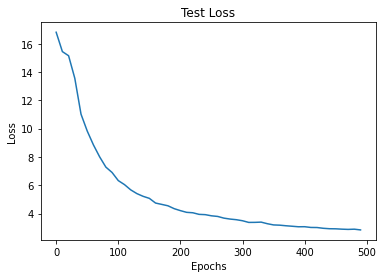

In [ ]:
plt.plot(Epochs,Test_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


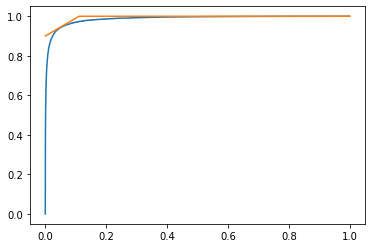

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=10
Y_train=label_binarize(Y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_train.T[:, i].T, Proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_train.T.ravel(), Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"])
plt.plot(fpr["macro"], tpr["macro"])


In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
confusion_matrix(y_train, predictions)

Confusion Matrix


array([[943,   0,   9,   4,   2,  21,   9,   4,   8,   0],
       [  0, 940,  14,   8,   1,   1,   0,   4,  30,   2],
       [ 11,  37, 831,  29,  17,  10,  30,  11,  22,   2],
       [  6,  13,  34, 829,   2,  54,   2,  19,  25,  16],
       [  0,   3,  13,   0, 862,   2,  25,   0,   9,  86],
       [ 30,   4,  18,  45,  16, 793,  21,   3,  59,  11],
       [ 11,   5,  20,   0,  21,  22, 900,   0,  19,   2],
       [  5,  18,   9,   7,   8,   1,   0, 870,   1,  81],
       [ 12,  26,  21,  37,   6,  55,  28,   1, 789,  25],
       [ 11,   1,   3,  19,  43,   7,   2,  41,  14, 859]])

SGD with Sigmoid

In [ ]:
model= MLPClassifier(0.1,500,'sigmoid')
W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs,Proba=model.fit(X_train,y_train,X_val,Y_val)

print('MLP accuracy With sigmoid',acc)

MLP accuracy With sigmoid 0.7077


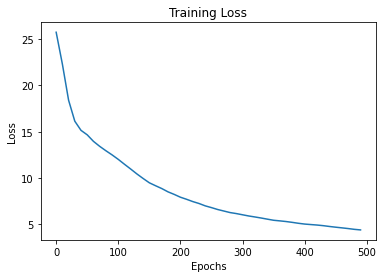

In [ ]:
plt.plot(Epochs,Train_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show() 

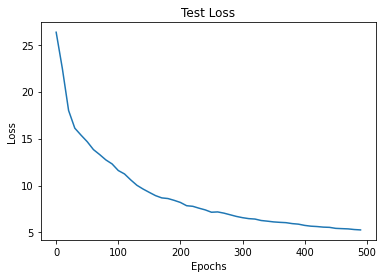

In [ ]:
plt.plot(Epochs,Test_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


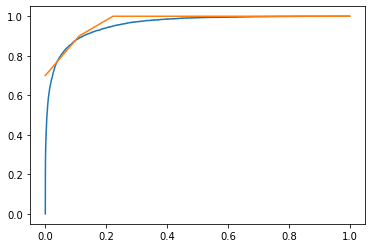

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=10
Y_train=label_binarize(Y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_train.T[:, i].T, Proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_train.T.ravel(), Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"])
plt.plot(fpr["macro"], tpr["macro"])


In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
confusion_matrix(y_train, predictions)

Confusion Matrix


array([[916,   1,  18,  18,   3,   4,  19,  11,  10,   0],
       [  0, 958,   5,   2,   1,  12,   0,   2,  14,   6],
       [ 52,  48, 736,  27,  22,   4,  75,  11,  14,  11],
       [ 88,  20,  21, 654,   5,  49,  10,  24,  80,  49],
       [  0,   9,  30,   1, 741,   7,  41,   4,  12, 155],
       [ 73,  34,  25, 147,  12, 505,  43,   8, 129,  24],
       [  7,  18,  65,   0,  40,   6, 847,   1,  16,   0],
       [ 11,  28,  12,   8,  20,   3,   1, 825,   4,  88],
       [ 11, 100,  35, 132,  23,  61,  58,   4, 511,  65],
       [ 12,   8,  21,  17, 133,   2,   4,  48,  16, 739]])

In [ ]:
model= MLPClassifier(0.1,500,'tanh')
W1, b1, W2, b2,predictions,acc,Train_loss,Test_loss,Epochs,Proba=model.fit(X_train,y_train,X_val,Y_val)

print('MLP accuracy With tanh',acc)

MLP accuracy With tanh 0.8133


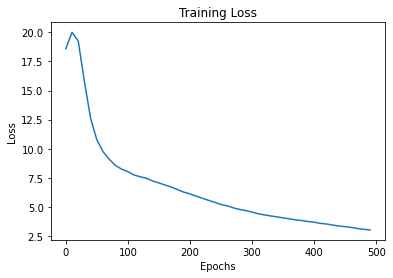

In [ ]:
plt.plot(Epochs,Train_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show() 

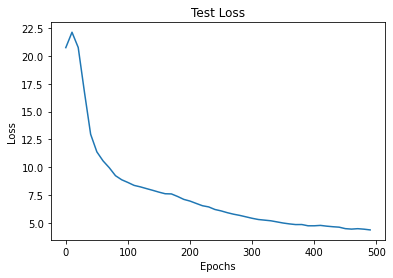

In [ ]:
plt.plot(Epochs,Test_loss)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


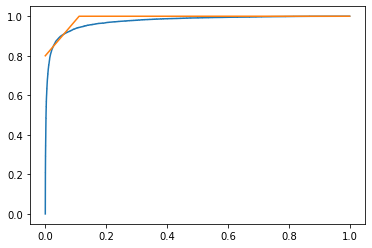

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=10
Y_train=label_binarize(Y_train, classes=[0, 1, 2,3,4,5,6,7,8,9])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_train.T[:, i].T, Proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_train.T.ravel(), Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"])
plt.plot(fpr["macro"], tpr["macro"])

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix')
confusion_matrix(y_train, predictions)

Confusion Matrix


array([[901,   0,  10,  34,   2,  36,  13,   1,   2,   1],
       [  0, 954,   7,   5,   4,   6,   0,   3,  18,   3],
       [ 28,  22, 751,  36,  22,   6,  41,  14,  77,   3],
       [ 19,  16,  46, 784,   4,  41,   0,  18,  44,  28],
       [  6,   8,  17,   1, 813,  10,  14,   6,  23, 102],
       [ 44,  23,   9,  91,  21, 717,  22,   2,  62,   9],
       [ 16,   3,  33,   0,   7,  14, 911,   1,  14,   1],
       [ 10,  15,  19,   1,  26,   2,   0, 865,  10,  52],
       [ 12,  21,  57,  44,  23,  67,  25,   5, 693,  53],
       [  5,   6,  13,  18,  81,   3,   4,  75,  12, 783]])